# Session 1: Introduction to Gaussian Processes and PyMC

**Duration:** 2–3 hours

## Learning Objectives

By the end of this session, you will be able to:

- Understand what Bayesian non-parametric models are and how Gaussian processes fit into this framework
- Connect the familiar concept of multivariate normal distributions to the more general idea of Gaussian processes
- Learn the basics of PyMC and how to implement Gaussian processes in code
- Understand the roles of mean and covariance functions in defining a GP's behavior
- Build and fit your first GP model using real data

## What Makes This Workshop Different

Throughout these notebooks, you'll notice sections marked with 🤖. These are **LLM-assisted exercises** where you'll practice using large language models (like ChatGPT, Claude, or your favorite coding assistant) to help you implement GP concepts. This approach reflects modern data science practice: knowing *what* you want to accomplish and *how* to verify it is often more important than memorizing every implementation detail.

The exercises are designed to help you develop the skill of effectively communicating with AI assistants—a critical ability in today's data science workflow. You'll learn to write clear prompts, test implementations, and validate results, building both your GP expertise and your collaborative coding skills.

## Section 1.1: Introduction and Setup

### What Does "Non-Parametric" Mean in a GP Context?

When we talk about Gaussian processes being "non-parametric," we're not saying they have no parameters—that would be confusing! Instead, we mean that GPs don't assume a fixed functional form with a finite number of parameters. 

Think about it this way: in linear regression, you commit to a straight line (or hyperplane) defined by a slope and intercept. You're making a strong assumption about the shape of your function before seeing the data. With a GP, you're defining a *distribution over functions*. The data then tells you which functions from this distribution are most plausible.

This flexibility makes GPs incredibly powerful for modeling complex, unknown relationships. The "parameters" in a GP are actually hyperparameters that control properties like smoothness and lengthscale—they shape the space of possible functions rather than defining a single function.

### Setting Up Our Environment

Before we dive into the mathematics and implementation, let's set up our Python environment with all the tools we'll need. We'll be using modern, efficient libraries throughout this workshop:

- **PyMC**: For probabilistic programming and GP implementation
- **NumPy 2.x**: For numerical computing
- **Polars**: For fast, efficient data manipulation (preferred over pandas)
- **Plotly**: For interactive, publication-quality visualizations
- **ArviZ**: For Bayesian analysis and diagnostics

Let's import everything and set up reproducibility:

In [1]:
import pymc as pm
import numpy as np
import polars as pl
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import arviz as az
import plotly.io as pio
from scipy import stats
import platform

if platform.system() == 'Linux':
    import multiprocessing as mp
    mp.set_start_method('spawn', force=True)

# Set random seed for reproducibility
RANDOM_SEED = 20090425
rng = np.random.default_rng(RANDOM_SEED)

# Configure plotly for nice interactive plots
pio.templates.default = "plotly_white"

# Print versions to verify environment
print(f"PyMC version: {pm.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Polars version: {pl.__version__}")
print(f"\nEnvironment ready! Let's explore Gaussian Processes.")

PyMC version: 5.25.1
NumPy version: 2.3.3
Polars version: 1.35.1

Environment ready! Let's explore Gaussian Processes.


Everything should import cleanly and you should see version numbers printed above. If you encounter any import errors, make sure your environment is set up correctly with PyMC 5.16+, NumPy 2.x, and Polars 1.x.

Notice that we're setting `RANDOM_SEED` right at the start. Reproducibility is crucial in Bayesian workflows—you want to be able to recreate your results exactly, especially when debugging or sharing your work with colleagues.

## Section 1.2: Bayesian Inference Primer

Before we dive into Gaussian processes, let's review the foundational concepts of Bayesian inference. If you're already comfortable with Bayes' theorem and Bayesian updating, think of this as a warm-up exercise. If these concepts are new, pay close attention—they're the bedrock on which everything else is built.

### Bayes' Theorem: The Foundation

At its heart, Bayesian inference is about updating beliefs with data. We start with prior knowledge or assumptions (the prior), observe some data (the likelihood), and combine them to get updated knowledge (the posterior):

$$P(\theta | y) \propto P(y | \theta) P(\theta)$$

This seemingly simple equation is incredibly powerful. It tells us:
- What we believe about parameters $\theta$ **after** seeing data $y$ (the posterior, left side)
- Is proportional to the probability of observing $y$ given $\theta$ (the likelihood) times what we believed **before** seeing data (the prior)

The proportionality constant is just a normalization factor that ensures probabilities sum to one—important mathematically, but not for understanding the intuition.

### A Simple Example: Estimating a Mean

Let's build intuition with a concrete example. Suppose we observe a few data points and want to estimate their mean. We'll use PyMC to build a simple Bayesian model.

Imagine we've measured the heights of five plants (in cm): 20.5, 22.1, 19.8, 21.0, 20.3. What can we infer about the true mean height?

In [2]:
# Our observed data
plant_heights = np.array([20.5, 22.1, 19.8, 21.0, 20.3])

# Build a simple Bayesian model
with pm.Model() as simple_model:
    # Prior: we believe the mean is somewhere around 20, but we're quite uncertain
    mu = pm.Normal('mu', mu=20, sigma=5)
    
    # We'll assume we know the measurement noise is about 1 cm
    sigma = 1.0
    
    # Likelihood: each observation is normally distributed around the true mean
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=plant_heights)
    
    # Sample from the posterior
    trace = pm.sample(1000, tune=1000, nuts_sampler='nutpie', random_seed=rng, return_inferencedata=True)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,1.26,1
,2000,0,1.45,3
,2000,0,1.31,1
,2000,0,1.35,3


Let's visualize what happened. We started with a prior belief (mean around 20, quite uncertain), observed data, and PyMC combined them to give us a posterior distribution:

In [3]:
# Extract posterior samples
posterior_samples = trace.posterior['mu'].values.flatten()

# Create figure
fig = go.Figure()

# Plot posterior distribution
fig.add_trace(go.Histogram(
    x=posterior_samples,
    histnorm='probability density',
    name='Posterior',
    opacity=0.7,
    marker_color='blue'
))

# Add prior distribution for comparison
x_range = np.linspace(15, 25, 200)
prior_density = stats.norm.pdf(x_range, 20, 5)
fig.add_trace(go.Scatter(
    x=x_range,
    y=prior_density,
    mode='lines',
    name='Prior',
    line=dict(color='red', width=2, dash='dash')
))

# Mark the observed mean
fig.add_vline(x=plant_heights.mean(), line_dash="dot", 
              line_color="green",
              annotation_text="Observed mean")

fig.update_layout(
    title='Prior and Posterior Distributions for Mean Height',
    xaxis_title='Mean Height (cm)',
    yaxis_title='Density',
    showlegend=True
)

fig.show()

Notice what happened: our posterior (blue histogram) is much more concentrated than our prior (red dashed line). The data informed our belief, pulling the distribution toward the observed mean (green line) and reducing our uncertainty. This is Bayesian updating in action!

The posterior distribution tells us everything we know about the mean after seeing the data. We can compute point estimates, credible intervals, or answer probability questions like "What's the probability the mean is above 21 cm?"

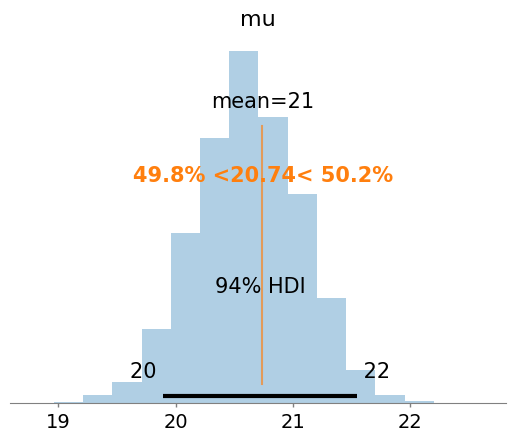

In [4]:
# Use ArviZ for a professional summary
az.plot_posterior(trace, var_names=['mu'], 
                  ref_val=plant_heights.mean(),
                  kind='hist');

ArviZ's `plot_posterior` gives us a clean summary: the mean and 94% highest density interval (HDI). The HDI is the Bayesian analog of a confidence interval—it's the narrowest interval containing 94% of the posterior probability.

This simple example embodies the three-step Bayesian workflow:
1. **Specify the model**: Define priors and likelihood
2. **Calculate the posterior**: Use MCMC sampling (we'll cover this in detail later)
3. **Check and interpret**: Visualize results and draw conclusions

Now that we've warmed up with basic Bayesian inference, we're ready to see how Gaussian processes extend these ideas to model entire functions rather than just parameters.

## Section 1.3: From Multivariate Normals to Gaussian Processes

### Building Intuition: Functions as Infinite-Dimensional Vectors

Here's the key insight that unlocks Gaussian processes: if you squint just right, a function is just a really long vector—infinitely long, in fact. At every point $x$ in the input space, the function has a value $f(x)$. You can think of $f$ as an infinite-dimensional vector, with one entry for each possible $x$.

Now, you already know what a multivariate normal (MVN) distribution is—it's a probability distribution over vectors. A Gaussian process is simply the natural extension of an MVN distribution to this infinite-dimensional case. It's a distribution over *functions*.

The magic is that we can work with GPs using only finite-dimensional operations. We never actually deal with infinity—we only care about the function values at the specific points where we have (or want) observations. Let's make this concrete.

### Drawing Functions from a GP Prior

A Gaussian process is completely specified by two functions:
- A **mean function** $m(x)$ that gives the expected value at each point
- A **covariance function** (or kernel) $k(x, x')$ that describes how function values at different points relate to each other

We write: $f(x) \sim \mathcal{GP}(m(x), k(x, x'))$

Let's implement a simple GP prior using the squared exponential (also called RBF or ExpQuad) kernel and draw some functions from it. First, we'll implement the kernel function ourselves to build intuition:

### 🤖 EXERCISE 1: Implement the ExpQuad Kernel

Let's start by implementing the exponential quadratic (RBF) kernel from scratch. This exercise will help you understand what a covariance function actually does.

In [5]:
# 🤖 EXERCISE: Use your LLM to help complete this implementation

# STEP 1: Ask your LLM to help you implement this function
def exp_quad_kernel(X1, X2, lengthscale=1.0, variance=1.0):
    """
    Compute the ExpQuad (RBF/Squared Exponential) covariance matrix.
    
    The ExpQuad kernel is: k(x, x') = variance * exp(-||x - x'||^2 / (2 * lengthscale^2))
    
    Parameters:
    -----------
    X1 : array-like, shape (n_samples_1, n_features)
        First input matrix
    X2 : array-like, shape (n_samples_2, n_features)  
        Second input matrix
    lengthscale : float
        Length scale parameter - controls how quickly correlation decays with distance
    variance : float
        Variance parameter - controls overall scale of function values
        
    Returns:
    --------
    K : array, shape (n_samples_1, n_samples_2)
        Covariance matrix
    
    Prompt suggestion: "Help me implement an RBF/ExpQuad kernel that returns the pairwise
    covariance matrix k(x, x') = sigma^2 * exp(-||x - x'||^2 / (2 * ell^2)) using NumPy 2.
    The inputs X1 and X2 should be 2D arrays where each row is a data point."
    """
    # REFERENCE SOLUTION (for instructors):
    # Compute squared Euclidean distances
    # For each pair (i,j), we need ||X1[i] - X2[j]||^2
    X1_sq = np.sum(X1**2, axis=1, keepdims=True)  # shape (n1, 1)
    X2_sq = np.sum(X2**2, axis=1, keepdims=True)  # shape (n2, 1)
    distances_sq = X1_sq + X2_sq.T - 2 * X1 @ X2.T  # shape (n1, n2)
    
    # Apply RBF kernel formula
    K = variance * np.exp(-distances_sq / (2 * lengthscale**2))
    return K

# STEP 2: Test your implementation
# Create a simple test case
X_test = np.array([[0.], [1.], [2.]])
K_test = exp_quad_kernel(X_test, X_test, lengthscale=1.0, variance=1.0)

print("Covariance matrix:")
print(K_test)
print("\nProperties to check:")
print(f"1. Symmetric? {np.allclose(K_test, K_test.T)}")
print(f"2. Diagonal values (should be ~{1.0}): {np.diag(K_test)}")
print(f"3. Positive semi-definite? {np.all(np.linalg.eigvals(K_test) >= -1e-10)}")

Covariance matrix:
[[1.         0.60653066 0.13533528]
 [0.60653066 1.         0.60653066]
 [0.13533528 0.60653066 1.        ]]

Properties to check:
1. Symmetric? True
2. Diagonal values (should be ~1.0): [1. 1. 1.]
3. Positive semi-definite? True


Let's visualize this kernel as a heatmap to understand what it's doing. The kernel matrix tells us how correlated function values are at different input locations:

In [6]:
# Create a grid of points
X_grid = np.linspace(0, 10, 50)[:, None]
K_grid = exp_quad_kernel(X_grid, X_grid, lengthscale=1.5, variance=1.0)

# Visualize the covariance matrix
fig = px.imshow(K_grid, 
                x=X_grid.flatten(),
                y=X_grid.flatten(),
                color_continuous_scale='Viridis',
                labels=dict(x="x", y="x'", color="Covariance"),
                title="ExpQuad Kernel: How function values covary")
fig.update_layout(width=600, height=500)
fig.show()

Notice the structure: the diagonal is bright (variance = 1.0), meaning each point is perfectly correlated with itself. As you move away from the diagonal, the correlation decays smoothly. This decay rate is controlled by the lengthscale parameter—it determines how far apart two points can be before they become essentially uncorrelated.

Now let's use this kernel to draw actual functions from a GP prior:

In [7]:
# Define input points where we want to evaluate the function
X = np.linspace(0, 10, 100)[:, None]

# Build the covariance matrix
lengthscale = 1.5
variance = 1.0
K = exp_quad_kernel(X, X, lengthscale=lengthscale, variance=variance)

# Add small jitter for numerical stability
K += 1e-8 * np.eye(len(X))

# Zero mean function (we'll explore non-zero means later)
mean = np.zeros(len(X))

# Draw 5 sample functions from the GP prior
n_samples = 5
f_samples = rng.multivariate_normal(mean, K, size=n_samples)

# Plot the sample functions
fig = go.Figure()
for i in range(n_samples):
    fig.add_trace(go.Scatter(
        x=X.flatten(),
        y=f_samples[i],
        mode='lines',
        name=f'Sample {i+1}',
        line=dict(width=2),
        opacity=0.7
    ))

fig.update_layout(
    title=f'Functions Drawn from GP Prior (lengthscale={lengthscale}, variance={variance})',
    xaxis_title='x',
    yaxis_title='f(x)',
    showlegend=True
)
fig.show()

These are functions drawn from our GP prior! Each colored line represents one possible function that the GP considers plausible before seeing any data. Notice how smooth they are—that smoothness comes from the ExpQuad kernel. 

Here's the beautiful thing: we just drew these functions by sampling from a multivariate normal distribution. The connection is direct:
- The mean vector of the MVN is our mean function evaluated at our input points
- The covariance matrix of the MVN is our kernel evaluated at all pairs of input points

### Understanding Lengthscale and Variance

Let's explore how the kernel parameters affect the functions we draw:

In [8]:
# Compare different lengthscales
lengthscales = [0.5, 1.5, 3.0]

fig = make_subplots(rows=1, cols=3,
                    subplot_titles=[f'lengthscale = {l}' for l in lengthscales])

for idx, ls in enumerate(lengthscales, 1):
    K = exp_quad_kernel(X, X, lengthscale=ls, variance=1.0)
    K += 1e-8 * np.eye(len(X))
    
    samples = rng.multivariate_normal(np.zeros(len(X)), K, size=3)
    
    for sample in samples:
        fig.add_trace(
            go.Scatter(x=X.flatten(), y=sample, mode='lines',
                      showlegend=False, line=dict(width=1.5)),
            row=1, col=idx
        )

fig.update_xaxes(title_text="x")
fig.update_yaxes(title_text="f(x)", col=1)
fig.update_layout(height=300, width=900,
                  title_text="Effect of Lengthscale on Function Smoothness")
fig.show()

The lengthscale parameter controls the "wiggliness" of functions:
- **Small lengthscale** (left): Functions vary rapidly, with high-frequency wiggles
- **Medium lengthscale** (middle): Smooth functions with moderate variation
- **Large lengthscale** (right): Very smooth, slowly varying functions

Think of lengthscale as answering the question: "How far do I need to move in input space before function values become uncorrelated?" This is one of the most important hyperparameters you'll tune when fitting GPs to real data.

The variance parameter, on the other hand, controls the typical distance of functions from the mean function (in this case, zero). Larger variance means larger excursions from the mean.

We've just connected multivariate normals to Gaussian processes! A GP is simply a generalization of the MVN to infinite dimensions, and we can work with it by considering only the finite set of points we care about. This is the key insight that makes GPs practical.

## Section 1.4: Mean Functions

### The Role of the Mean Function

So far, we've been using a zero mean function, but this is just one choice among many. The mean function $m(x)$ specifies the expected value of the function at each input point, before we see any data. Think of it as your baseline assumption about what the function looks like.

The mean function shifts functions up or down (or even gives them a trend), but it doesn't affect their smoothness or correlation structure—that's the job of the covariance function. In many applications, we stick with a zero mean because:
1. It's simple and introduces no additional parameters
2. The covariance function is usually flexible enough to capture the important structure
3. If we're working with standardized data (mean-centered), a zero mean function makes sense

However, when you have strong prior knowledge about the general shape of your function—maybe you know it should have a linear trend or oscillate around some value—encoding this in the mean function can improve your model.

Let's explore the three most common mean functions: zero, constant, and linear.

In [9]:
# Define our input points
X_mean = np.linspace(0, 10, 100)[:, None]
n_samples = 3

# Shared covariance (we'll use the same kernel for all)
K = exp_quad_kernel(X_mean, X_mean, lengthscale=1.5, variance=1.0)
K += 1e-8 * np.eye(len(X_mean))

# Three different mean functions
mean_zero = np.zeros(len(X_mean))
mean_constant = np.full(len(X_mean), 5.0)  # Constant offset of 5
mean_linear = 0.5 * X_mean.flatten() + 2.0  # Linear trend

# Create subplots
fig = make_subplots(rows=1, cols=3,
                    subplot_titles=['Zero Mean', 'Constant Mean (5.0)', 'Linear Mean (0.5x + 2)'])

for idx, (mean_func, title) in enumerate([
    (mean_zero, 'Zero'),
    (mean_constant, 'Constant'),
    (mean_linear, 'Linear')
], 1):
    # Draw samples
    samples = rng.multivariate_normal(mean_func, K, size=n_samples)
    
    # Plot mean function
    fig.add_trace(
        go.Scatter(x=X_mean.flatten(), y=mean_func, mode='lines',
                  line=dict(color='black', width=3, dash='dash'),
                  showlegend=False, name='Mean'),
        row=1, col=idx
    )
    
    # Plot samples
    for sample in samples:
        fig.add_trace(
            go.Scatter(x=X_mean.flatten(), y=sample, mode='lines',
                      showlegend=False, line=dict(width=1.5), opacity=0.7),
            row=1, col=idx
        )

fig.update_xaxes(title_text="x")
fig.update_yaxes(title_text="f(x)", col=1)
fig.update_layout(height=300, width=900,
                  title_text="GP Prior Samples with Different Mean Functions (black dashed = mean)")
fig.show()

Notice how the mean function (black dashed line) acts as an "anchor" around which the random functions vary:

- **Zero mean** (left): Functions wander around zero, with equal probability of being positive or negative
- **Constant mean** (middle): Functions are shifted up to fluctuate around 5.0, but remain roughly constant on average
- **Linear mean** (right): Functions inherit the upward trend, but with wiggles around that trend

The key insight: the covariance function determines the smoothness and correlation structure (how wiggly the functions are), while the mean function determines where they're centered or whether they have a systematic trend. They work together, but control different aspects of the prior.

### When to Use Each Mean Function

Here's a practical guide:

- **Zero mean**: Default choice, especially with standardized data or when you have no strong prior beliefs
- **Constant mean**: When you expect the function to fluctuate around some non-zero value (e.g., temperature anomalies around a baseline)
- **Linear mean**: When you have a clear trend in your data and want the GP to model deviations from that trend

In PyMC, you can easily specify these using built-in mean functions:

In [10]:
# PyMC makes it easy to specify mean functions
mean_zero_pymc = pm.gp.mean.Zero()  # Default
mean_const_pymc = pm.gp.mean.Constant(c=5.0)
mean_linear_pymc = pm.gp.mean.Linear(coeffs=0.5, intercept=2.0)

# Test them
X_test = np.array([[0.], [5.], [10.]])
print("Zero mean:", mean_zero_pymc(X_test).eval())
print("Constant mean:", mean_const_pymc(X_test).eval())
print("Linear mean:", mean_linear_pymc(X_test).eval())

Zero mean: [0. 0. 0.]
Constant mean: [5. 5. 5.]
Linear mean: [2.  4.5 7. ]


### 🤖 EXERCISE 2: Compare Different Mean Functions

Now let's explore how different mean functions affect GP prior draws more systematically.

In [11]:
# 🤖 EXERCISE: Use your LLM to help complete this implementation

def compare_mean_functions(X, n_samples=5, lengthscale=1.5, variance=1.0):
    """
    Create comparison plots of GP priors with different mean functions.
    
    Parameters:
    -----------
    X : array, shape (n_points, 1)
        Input locations
    n_samples : int
        Number of function samples to draw from each GP
    lengthscale : float
        Kernel lengthscale
    variance : float
        Kernel variance
        
    Returns:
    --------
    fig : plotly Figure
        Comparison plot
    
    Prompt suggestion: "Help me write a function that compares GP prior samples using 
    three different mean functions: zero, constant (value=5), and linear (slope=0.5, intercept=2).
    Use the exp_quad_kernel defined earlier and create side-by-side Plotly subplots showing
    samples from each GP. Draw the mean function as a dashed black line and samples as colored lines."
    """
    # REFERENCE SOLUTION:
    K = exp_quad_kernel(X, X, lengthscale=lengthscale, variance=variance)
    K += 1e-8 * np.eye(len(X))
    
    means = {
        'Zero': np.zeros(len(X)),
        'Constant (5.0)': np.full(len(X), 5.0),
        'Linear (0.5x + 2)': 0.5 * X.flatten() + 2.0
    }
    
    fig = make_subplots(rows=1, cols=3, subplot_titles=list(means.keys()))
    
    for idx, (name, mean_func) in enumerate(means.items(), 1):
        samples = rng.multivariate_normal(mean_func, K, size=n_samples)
        
        # Plot mean
        fig.add_trace(
            go.Scatter(x=X.flatten(), y=mean_func, mode='lines',
                      line=dict(color='black', width=2, dash='dash'),
                      name='Mean', showlegend=(idx==1)),
            row=1, col=idx
        )
        
        # Plot samples
        for i, sample in enumerate(samples):
            fig.add_trace(
                go.Scatter(x=X.flatten(), y=sample, mode='lines',
                          name=f'Sample {i+1}' if idx==1 else None,
                          showlegend=(idx==1), line=dict(width=1.5),
                          opacity=0.7),
                row=1, col=idx
            )
    
    fig.update_xaxes(title_text="x")
    fig.update_yaxes(title_text="f(x)", col=1)
    fig.update_layout(height=350, width=1000,
                      title_text="Comparing Different Mean Functions")
    return fig

# Test the function
X_compare = np.linspace(0, 10, 100)[:, None]
fig = compare_mean_functions(X_compare, n_samples=5)
fig.show()

The exercise above reinforces an important point: **the mean function doesn't change the "wiggliness" or correlation structure**—that's entirely determined by the covariance function. The mean function simply shifts or tilts the family of functions we're considering.

In practice, most GP applications use a zero or constant mean function, letting the flexible covariance function do the heavy lifting. Now let's dive deep into those covariance functions!

## Section 1.5: Covariance Functions

### The Heart of Gaussian Processes

If the mean function is where your prior belief lives, the covariance function (or kernel) is where the magic happens. The kernel defines the structure, smoothness, and patterns that your GP can express. Choosing the right kernel is often the most important modeling decision you'll make.

A covariance function $k(x, x')$ must satisfy one critical property: it must produce **positive semi-definite covariance matrices** for any set of input points. This ensures that the resulting multivariate normal distributions are valid. Fortunately, PyMC provides a rich library of kernels that satisfy this property, and you can combine them in powerful ways.

Let's explore the most commonly used kernels and understand when to use each.

In [12]:
# Helper function to visualize kernels
def visualize_kernel(cov_func, X, title, n_samples=3):
    """Visualize kernel covariance matrix and sample functions."""
    K = cov_func(X).eval()
    K += 1e-6 * np.eye(len(X))
    
    fig = make_subplots(rows=1, cols=2, subplot_titles=['Covariance Matrix', 'Sample Functions'],
                        specs=[[{'type': 'heatmap'}, {'type': 'scatter'}]])
    
    # Covariance matrix heatmap
    fig.add_trace(go.Heatmap(z=K, colorscale='Viridis', showscale=True), row=1, col=1)
    
    # Sample functions
    samples = rng.multivariate_normal(np.zeros(len(X)), K, size=n_samples)
    for sample in samples:
        fig.add_trace(go.Scatter(x=X.flatten(), y=sample, mode='lines', showlegend=False, line=dict(width=1.5)), row=1, col=2)
    
    fig.update_xaxes(title_text="Index", row=1, col=1)
    fig.update_yaxes(title_text="Index", row=1, col=1)
    fig.update_xaxes(title_text="x", row=1, col=2)
    fig.update_yaxes(title_text="f(x)", row=1, col=2)
    fig.update_layout(height=350, width=900, title_text=title)
    return fig

# Grid for visualization
X_kern = np.linspace(0, 10, 80)[:, None]

### ExpQuad (Squared Exponential / RBF)

We've already seen this kernel! It's infinitely differentiable, producing extremely smooth functions. Use it when you expect your function to be smooth everywhere.

$$k(x, x') = \sigma^2 \exp\left(-\frac{\|x - x'\|^2}{2\ell^2}\right)$$

In [13]:
cov_expquad = pm.gp.cov.ExpQuad(input_dim=1, ls=1.5)
fig = visualize_kernel(cov_expquad, X_kern, "ExpQuad Kernel")
fig.show()

### Matérn Family

The Matérn kernels generalize the ExpQuad by controlling smoothness through a parameter $\nu$. Smaller $\nu$ means less smooth. PyMC provides three variants:

- **Matérn 1/2**: Continuous but not differentiable (roughest)
- **Matérn 3/2**: Once differentiable (medium smoothness)
- **Matérn 5/2**: Twice differentiable (smooth, but not as extreme as ExpQuad)

Use Matérn when you want control over smoothness or when your function might not be infinitely smooth.

In [14]:
# Compare Matérn kernels
matern_kernels = [
    (pm.gp.cov.Matern12(input_dim=1, ls=1.5), "Matérn 1/2 (Exponential)"),
    (pm.gp.cov.Matern32(input_dim=1, ls=1.5), "Matérn 3/2"),
    (pm.gp.cov.Matern52(input_dim=1, ls=1.5), "Matérn 5/2")
]

for cov, title in matern_kernels:
    fig = visualize_kernel(cov, X_kern, title)
    fig.show()

Notice how the functions become progressively smoother as we go from Matérn 1/2 to 5/2. The Matérn 1/2 (also called Exponential kernel) produces jagged, continuous but non-differentiable functions—perfect for modeling rough phenomena.

### Periodic Kernel

When your data has periodic structure (seasons, daily cycles, etc.), the Periodic kernel is your friend:

$$k(x, x') = \sigma^2 \exp\left(-\frac{2\sin^2(\pi|x - x'|/T)}{\ell^2}\right)$$

where $T$ is the period. This kernel enforces exact periodicity.

In [15]:
cov_periodic = pm.gp.cov.Periodic(input_dim=1, period=3.0, ls=1.0)
fig = visualize_kernel(cov_periodic, X_kern, "Periodic Kernel (period=3.0)")
fig.show()

See the repeating pattern? Functions drawn from this GP will have exact periodicity. In real applications, you often combine Periodic with other kernels to model periodic trends that slowly evolve over time.

### 🤖 EXERCISE 3: Explore Lengthscale Effects

Let's explore how lengthscale affects different kernels systematically.

In [16]:
# 🤖 EXERCISE: Use your LLM to help complete this visualization

def visualize_lengthscale_effects(X, lengthscales=(0.3, 1.0, 3.0), kernel_type='ExpQuad'):
    """
    Visualize how lengthscale affects GP prior samples.
    
    Parameters:
    -----------
    X : array
        Input points
    lengthscales : tuple
        Different lengthscales to compare
    kernel_type : str
        'ExpQuad', 'Matern32', or 'Matern52'
        
    Prompt suggestion: "Help me create a function that draws GP prior samples
    for multiple lengthscales using PyMC kernels. Create Plotly subplots showing
    3 functions for each lengthscale. Support ExpQuad, Matern32, and Matern52 kernels."
    """
    # REFERENCE SOLUTION:
    fig = make_subplots(rows=1, cols=len(lengthscales),
                        subplot_titles=[f'lengthscale = {ls}' for ls in lengthscales])
    
    for idx, ls in enumerate(lengthscales, 1):
        # Select kernel
        if kernel_type == 'ExpQuad':
            cov = pm.gp.cov.ExpQuad(input_dim=1, ls=ls)
        elif kernel_type == 'Matern32':
            cov = pm.gp.cov.Matern32(input_dim=1, ls=ls)
        elif kernel_type == 'Matern52':
            cov = pm.gp.cov.Matern52(input_dim=1, ls=ls)
        
        K = cov(X).eval() + 1e-6 * np.eye(len(X))
        samples = rng.multivariate_normal(np.zeros(len(X)), K, size=3)
        
        for sample in samples:
            fig.add_trace(
                go.Scatter(x=X.flatten(), y=sample, mode='lines',
                          showlegend=False, line=dict(width=1.5)),
                row=1, col=idx
            )
    
    fig.update_xaxes(title_text="x")
    fig.update_yaxes(title_text="f(x)", col=1)
    fig.update_layout(height=300, width=1000,
                      title_text=f"Lengthscale Effects on {kernel_type} Kernel")
    return fig

# Test with different kernels
X_test = np.linspace(0, 10, 100)[:, None]
for kernel in ['ExpQuad', 'Matern32', 'Matern52']:
    fig = visualize_lengthscale_effects(X_test, kernel_type=kernel)
    fig.show()

The exercise above demonstrates that lengthscale has consistent effects across kernel families: smaller lengthscales create more rapidly varying functions, while larger lengthscales produce smoother, slowly varying functions. The kernel family (ExpQuad vs. Matérn) controls the *type* of smoothness, while lengthscale controls the *scale* at which variation occurs.

Now you have a solid understanding of the main kernel building blocks. In Session 2, we'll explore how to combine these kernels to model complex phenomena like trends plus seasonality!

## Section 1.6: Your First PyMC GP Model

### From Theory to Practice

We've explored the theory of Gaussian processes, implemented kernels from scratch, and visualized prior distributions. Now comes the exciting part: fitting a GP to real data and making predictions!

### The Problem: Modeling Atmospheric CO₂

Let's work with a classic GP dataset: monthly atmospheric CO₂ measurements from Mauna Loa Observatory. We'll use a subset of the data to fit a simple GP model.

First, let's generate some synthetic smooth data with noise to illustrate the GP regression workflow (we can easily adapt this to real CO₂ data later):

In [17]:
# Generate synthetic data: a smooth function with Gaussian noise
np.random.seed(RANDOM_SEED)
n_data = 50
X_data = np.sort(rng.uniform(0, 10, n_data))[:, None]

# True underlying function: a combination of sine and linear trend
f_true = 2 * np.sin(X_data.flatten()) + 0.5 * X_data.flatten()
sigma_noise = 0.5
y_data = f_true + sigma_noise * rng.standard_normal(n_data)

# Plot the data
fig = go.Figure()
fig.add_trace(go.Scatter(x=X_data.flatten(), y=y_data, mode='markers',
                         name='Observed Data', marker=dict(size=6, color='blue')))
fig.add_trace(go.Scatter(x=X_data.flatten(), y=f_true, mode='lines',
                         name='True Function', line=dict(color='red', width=2, dash='dash')))
fig.update_layout(title='Synthetic Data: Observations and True Function',
                  xaxis_title='x', yaxis_title='y')
fig.show()

We can see there's a smooth underlying function (red dashed line) obscured by observation noise (blue points). Our goal is to use a GP to recover the true function and quantify our uncertainty.

### Building the GP Model in PyMC

Here's where PyMC's `gp.Marginal` class comes in. It implements GP regression with Gaussian noise efficiently by analytically integrating out the latent function values. The model structure is:

$$\begin{aligned}
f(x) &\sim \mathcal{GP}(m(x), k(x, x')) \\
y_i &\sim \text{Normal}(f(x_i), \sigma)
\end{aligned}$$

Let's build this step by step:

In [18]:
with pm.Model() as gp_model:
    # Priors for kernel hyperparameters
    # Lengthscale: how quickly the function varies
    ell = pm.Gamma('ell', alpha=2, beta=1)
    # Amplitude: typical scale of function values
    eta = pm.HalfNormal('eta', sigma=3)
    
    # Covariance function
    cov_func = eta**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ell)
    
    # GP prior with zero mean
    gp = pm.gp.Marginal(cov_func=cov_func)
    
    # Noise variance prior
    sigma = pm.HalfNormal('sigma', sigma=2)
    
    # Marginal likelihood
    y_obs = gp.marginal_likelihood('y_obs', X=X_data, y=y_data, sigma=sigma)
    
    # Sample from posterior
    trace_gp = pm.sample(1000, tune=1000, nuts_sampler='nutpie', random_seed=rng, return_inferencedata=True)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.85,3
,2000,0,0.86,3
,2000,2,0.74,7
,2000,0,0.88,7


Let's examine what we learned about the hyperparameters:

In [19]:
# Summary of hyperparameter posteriors
az.summary(trace_gp, var_names=['ell', 'eta', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ell,1.605,0.435,0.870,2.387,0.011,0.007,1606.0,2272.0,1.0
eta,3.343,1.026,1.692,5.194,0.025,0.026,2063.0,1904.0,1.0
sigma,0.529,0.068,0.408,0.655,0.001,0.001,2472.0,2383.0,1.0


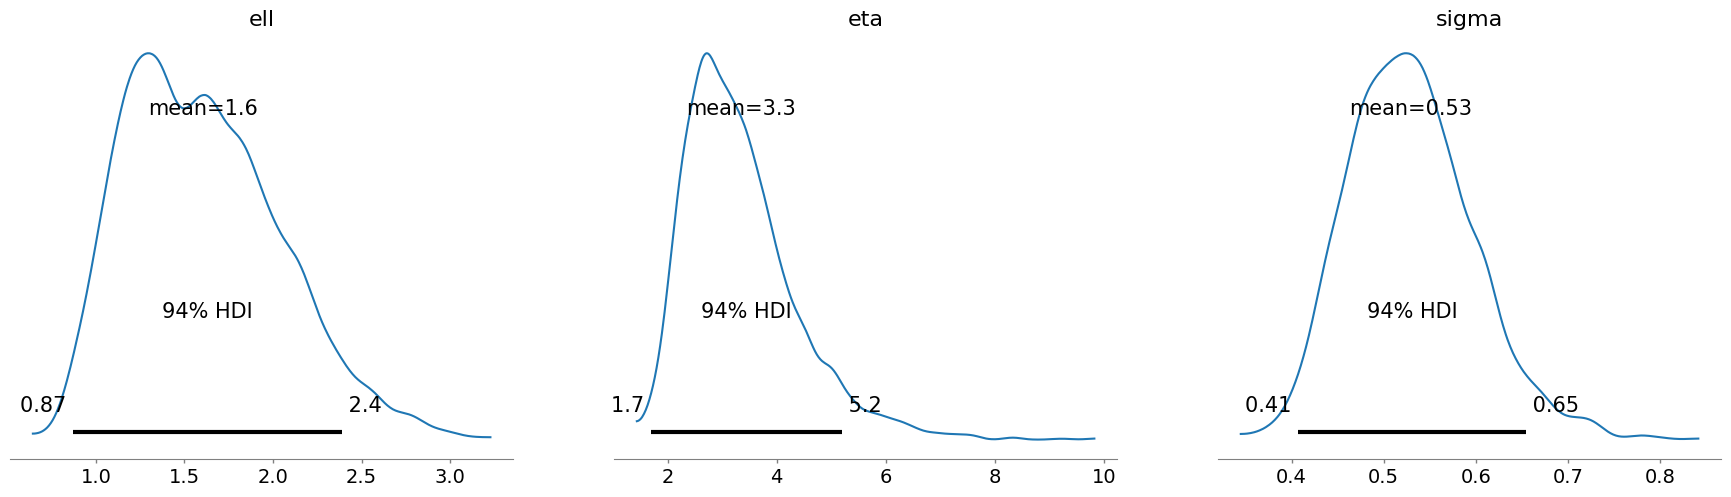

In [20]:
# Visualize hyperparameter posteriors
az.plot_posterior(trace_gp, var_names=['ell', 'eta', 'sigma']);

The posterior distributions tell us what lengthscale, amplitude, and noise level are most consistent with the observed data. Notice that we now have uncertainty quantified for these hyperparameters—this is a key advantage of the Bayesian approach!

### Making Predictions

Now for the payoff: using our fitted GP to make predictions at new locations.

In [21]:
# New points for prediction
X_new = np.linspace(-1, 11, 200)[:, None]

# Add conditional distribution for predictions
with gp_model:
    f_pred = gp.conditional('f_pred', X_new)
    # Sample from posterior predictive
    pred_samples = pm.sample_posterior_predictive(
        trace_gp, var_names=['f_pred'], random_seed=rng
    )

Sampling: [f_pred]


Output()

Let's visualize the predictions with uncertainty bands:

In [22]:
# Extract posterior predictive samples
f_pred_samples = pred_samples.posterior_predictive['f_pred'].values
f_pred_mean = f_pred_samples.mean(axis=(0, 1))
f_pred_lower = np.percentile(f_pred_samples, 2.5, axis=(0, 1))
f_pred_upper = np.percentile(f_pred_samples, 97.5, axis=(0, 1))

# Create plot
fig = go.Figure()

# Credible interval
fig.add_trace(go.Scatter(
    x=np.concatenate([X_new.flatten(), X_new.flatten()[::-1]]),
    y=np.concatenate([f_pred_upper, f_pred_lower[::-1]]),
    fill='toself',
    fillcolor='rgba(0,100,250,0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    name='95% Credible Interval',
    showlegend=True
))

# Posterior mean
fig.add_trace(go.Scatter(
    x=X_new.flatten(), y=f_pred_mean,
    mode='lines', name='Posterior Mean',
    line=dict(color='blue', width=2)
))

# Observed data
fig.add_trace(go.Scatter(
    x=X_data.flatten(), y=y_data,
    mode='markers', name='Observed Data',
    marker=dict(size=8, color='red', symbol='circle')
))

fig.update_layout(
    title='GP Posterior: Mean and 95% Credible Interval',
    xaxis_title='x',
    yaxis_title='y',
    showlegend=True
)
fig.show()

This plot captures the essence of Gaussian process regression:

- **Blue line**: The posterior mean—our best guess for the function
- **Shaded region**: 95% credible interval—where we think the true function lies with 95% probability
- **Red points**: Observed data

Notice several key features:
1. **Near data**: The credible interval is narrow—we're confident because we have observations nearby
2. **Away from data**: The interval widens—uncertainty grows as we extrapolate
3. **Smoothness**: The posterior mean is smooth, reflecting our ExpQuad kernel prior
4. **Interpolation**: The GP naturally interpolates between observations

This automatic quantification of uncertainty is one of the GP's superpowers. We're not just predicting—we're telling you how confident we are in each prediction.

### Model Checking with ArviZ

Before trusting our model, we should check MCMC diagnostics:

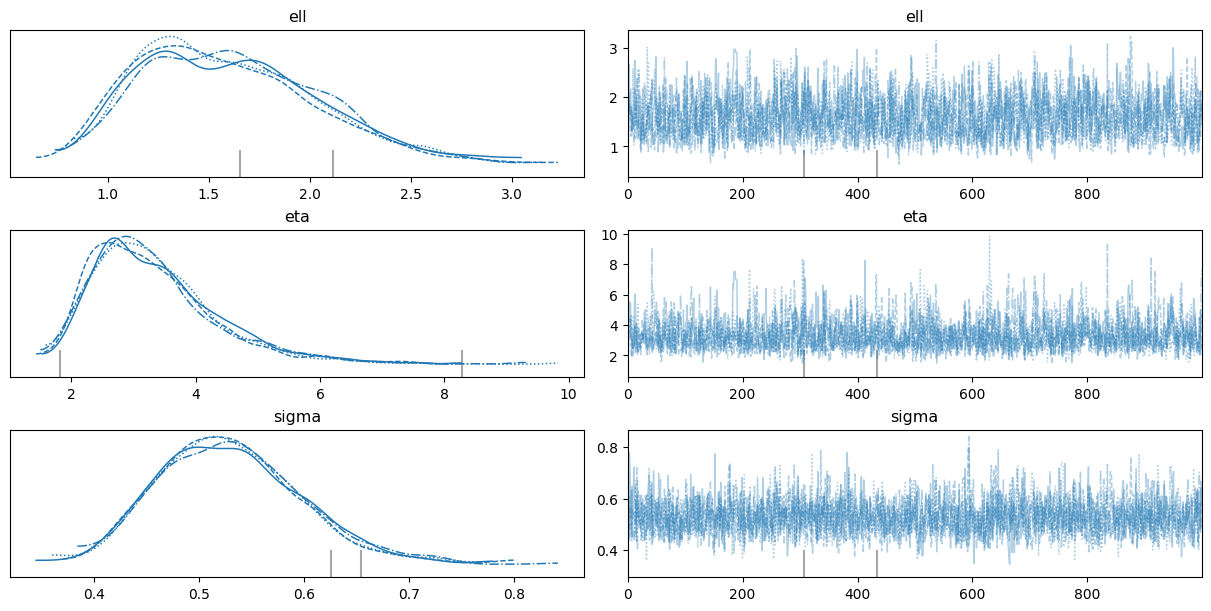

In [24]:
# Check convergence diagnostics
az.plot_trace(trace_gp, var_names=['ell', 'eta', 'sigma'], backend_kwargs={'constrained_layout': True});

Look for "fuzzy caterpillars" in the trace plots—this indicates good mixing and convergence. The distributions on the right should be smooth and well-behaved.

Congratulations! You've just fit your first Gaussian process model from scratch using PyMC. You've:
- Specified priors for hyperparameters
- Defined a GP with a covariance function
- Fit the model to data using MCMC
- Made predictions with quantified uncertainty
- Checked model diagnostics

This is the complete Bayesian GP workflow!

## Section 1.7: Summary and Next Steps

### What We've Learned

In this session, we've built a solid foundation for working with Gaussian processes:

1. **The Big Picture**: GPs are distributions over functions, generalizing multivariate normals to infinite dimensions. They're "non-parametric" because they don't assume a fixed functional form.

2. **Mean Functions**: Control the expected value of the function at each point. Most often we use zero or constant means, letting the kernel do the heavy lifting.

3. **Covariance Functions (Kernels)**: The heart of the GP. They encode assumptions about smoothness, periodicity, and correlation structure. We explored:
   - ExpQuad: Infinitely smooth functions
   - Matérn family: Controlled smoothness
   - Periodic: For cyclic phenomena

4. **Lengthscale**: One of the most important hyperparameters—controls the "wiggliness" and how quickly correlation decays with distance.

5. **PyMC Implementation**: We built and fit a complete GP model using `pm.gp.Marginal`, sampled from the posterior, and made predictions with uncertainty quantification.

### Key Intuitions to Remember

- A GP at finite points is just a multivariate normal—we draw functions by sampling from this MVN
- The kernel matrix tells you how correlated different input points are
- Uncertainty grows as you move away from observed data—GPs naturally know what they don't know
- Hyperparameters are learned from data through Bayesian inference

### Looking Ahead to Session 2

We've covered the fundamentals, but there's so much more! In Session 2, we'll explore:

- **Kernel Composition**: Adding and multiplying kernels to model complex patterns (trend + seasonality, interactions)
- **Marginal vs. Latent GPs**: When to use `gp.Marginal` vs. `gp.Latent` and the trade-offs
- **Non-Gaussian Likelihoods**: Classification, count data, robust regression with Student-T
- **Real-World Applications**: Modeling time series with multiple components

### Practice Suggestions

To solidify your understanding, try:
1. Modify the lengthscale priors in Section 1.6 and see how it affects the fit
2. Experiment with different kernels (try Matérn52 instead of ExpQuad)
3. Generate data with different patterns (periodic, polynomial) and fit GPs to them
4. Use your LLM assistant to help implement a custom composite kernel

GPs are a powerful tool in your machine learning arsenal. With the foundation we've built today, you're ready to tackle more advanced applications. See you in Session 2!